In [1]:
import re
import string
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
%matplotlib inline

# Load Data

In [2]:
dir_data = '../data/nba_reg18/'

ds_sub = pd.DataFrame()
ds_com = pd.DataFrame()

nf_subs = 7 #7 files for submissions
nf_coms = 12 #12 files for comments

In [3]:
for icom in range(1, nf_subs+1):
    path_ds = dir_data + 'nba_submissions_reg18_' + str(icom) + '.csv'
    ds_cur = pd.read_csv(path_ds, index_col = 0, parse_dates = ['created'])
    ds_sub = ds_sub.append(ds_cur).drop_duplicates()

In [4]:
for icom in range(1, nf_coms+1):
    path_ds = dir_data + 'nba_comments_reg18_' + str(icom) + '.csv'
    ds_cur = pd.read_csv(path_ds, index_col = 0, parse_dates = ['created'])
    ds_com = ds_com.append(ds_cur).drop_duplicates()

In [5]:
print('No. of threads:')
print(ds_sub.shape[0])
print('No. of comments:')
print(ds_com.shape[0])

No. of threads:
92383
No. of comments:
2064767


### Standerdize Team Name

In [6]:
import sys
sys.path.insert(1, '../scripts') #add my scripts path
from teamname_stdize import teamname_stdize

In [7]:
# get rid of the weired pandas float nan
ds_com.loc[ds_com['flair'].isnull().values, 'flair'] = 'NONE'
ds_sub.loc[ds_sub['flair'].isnull().values, 'flair'] = 'NONE'

In [8]:
# mapping to abbrev team name
ds_sub = teamname_stdize(ds_sub.rename(columns={'flair':'team'}))
ds_com = teamname_stdize(ds_com.rename(columns={'flair':'team'}))

In [9]:
# load team names
team_names = pd.read_csv('../data/teams', names = ['name', 'abbrs'])
team_abbrs = team_names['abbrs'].to_list()

In [10]:
print('No. Total threads:')
print(ds_sub.shape[0])
ds_sub = ds_sub.loc[ds_sub['team'].isin(team_abbrs), :]
print('No. Threads for 31 Teams:')
print(ds_sub.shape[0])

No. Total threads:
92383
No. Threads for 31 Teams:
55475


In [11]:
print('No. Total comments:')
print(ds_com.shape[0])
ds_com = ds_com.loc[ds_com['team'].isin(team_abbrs), :]
print('No. comments for 31 Teams:')
print(ds_com.shape[0])

No. Total comments:
2064767
No. comments for 31 Teams:
1562342


In [12]:
# put submissions and comments together
ds = pd.concat([ds_sub[['author', 'team', 'title', 'created']].rename(columns = {'title':'text'}),
                ds_com[['author', 'team', 'text', 'created']]],
               ignore_index = True)

In [13]:
print('No. Total posts:')
print(ds.shape[0])

No. Total posts:
1617817


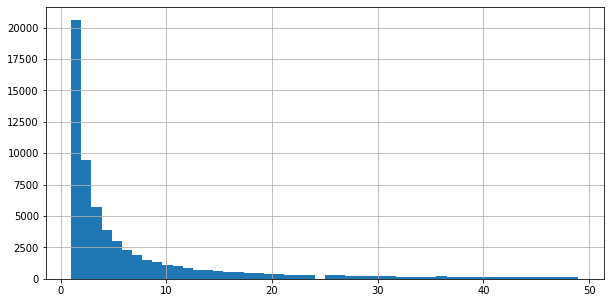

In [14]:
# plot the distribution of No. posts by user
txt_by_au = ds.groupby('author')['author'].count()
txt_by_au[(txt_by_au < 50)].hist(bins = 50, figsize=(10,5))

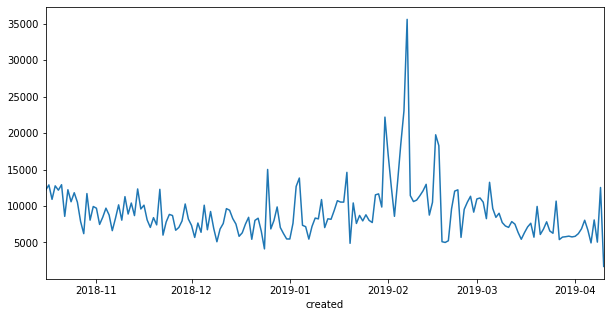

In [15]:
# plot the fluctuation of No. posts across the season by day
daily_posts = ds.groupby(ds['created'].dt.date)['text'].count()
daily_posts[daily_posts.index<date(2019,4,11)].plot(figsize=(10,5))

In [17]:
# look into top days:
daily_posts.sort_values(ascending = False).head(n=20)
# 2/7/2019: trade deadline
# 2/16/2019: all-star weekend
# 12/25/2018: Chrismas games, Lebron James injured

created
2019-02-07    35587
2019-02-06    23043
2019-01-31    22184
2019-02-16    19762
2019-02-05    18475
2019-02-17    18271
2019-02-01    17116
2018-12-25    15008
2019-01-19    14611
2019-01-04    13831
2019-02-04    13354
2019-03-05    13245
2019-02-13    12969
2018-10-21    12914
2018-10-17    12887
2018-10-19    12760
2019-01-03    12685
2019-02-02    12661
2019-04-09    12535
2018-11-14    12335
Name: text, dtype: int64

# Text Preprocessing

In [ ]:
# remove links and emojis
ds['text'] = ds['text'].map(lambda x: re.sub(r'((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?', ' ', str(x)))

In [ ]:
def replace_punctuation(text):
    #replace punctuation with space
    no_punct = ''.join([c if c not in string.punctuation else ' ' for c in text])
    #replace special char like 🏀
    no_punct = no_punct.encode('ascii', 'ignore').decode('ascii')
    #remove \n \t \r
    return no_punct.translate(str.maketrans("\n\t\r", "   "))

In [ ]:
ds['text'] = ds['text'].apply(replace_punctuation)

# Get Game Time Data (who posted during a team's games, didn't use in the end)

In [ ]:
# load game data
gametime = pd.read_csv('../data/game_schedule_reg18.csv',
                       names = ['date', 'time', 'visitor', 'vpts', 'home', 'hpts',
                                  'box', 'ot', 'attend', 'notes'],
                      skiprows=1).drop(['box', 'notes'], axis=1)

In [ ]:
# combine date&time to datetime
form = '%a %b %d %Y %I:%M%p'
def dataplustime(ds):
    return datetime.strptime(ds['date'] + ' ' + ds['time'] + 'm', form)

In [ ]:
gametime['datetime'] = gametime[['date', 'time']].apply(dataplustime, axis=1)
gametime.drop(['date', 'time'], axis = 1, inplace=True)

In [ ]:
# add overtimes to game time (10 min extension per overtime)
# get rid of the float nan
gametime.loc[gametime['ot'].isnull(), 'ot'] = 'NAN'

In [ ]:
# count how many OTs
def count_ots(ot):
    if ot == 'NAN':
        return 0
    elif ot == 'OT':
        return 1
    else:
        return int(ot[0])

In [ ]:
gametime['ot'] = gametime['ot'].apply(count_ots)

In [ ]:
# standerdize team name
gametime['visitor'] = gametime['visitor'].apply(flair2team, args = [team_dict, team_fulls, team_abbrs])
gametime['home'] = gametime['home'].apply(flair2team, args = [team_dict, team_fulls, team_abbrs])

In [ ]:
# concat home/visitor games together
tgame = pd.concat([gametime[['visitor', 'datetime', 'ot']].rename(columns = {'visitor':'team'}),
                  gametime[['home', 'datetime', 'ot']].rename(columns = {'home':'team'})])

In [ ]:
# calculate end_time for games
duration = 2.5 #2.5 hrs per game
ot_duration = 10 #10 min per OT
tgame['end_time'] = tgame['datetime'] + pd.Timedelta(duration, unit='h') + tgame['ot'].apply(lambda x: pd.Timedelta(x*ot_duration, unit='m'))
tgame = tgame.rename(columns={'datetime':'start_time'}).drop('ot', axis = 1)

In [ ]:
# tuple (start_time, end_time)
tgame['time_span'] = list(zip(tgame['start_time'], tgame['end_time']))
# group by team, each team get a list of game time tuples
ttgame = tgame.drop(['start_time', 'end_time'], axis=1).groupby('team')['time_span'].apply(list)

In [ ]:
# go through the dataset, assign game time tags for each entry (posted during X team's games, 30 columns added)
for team, time in ttgame.items():
    ds[team] = 0
    for ts, te in time:
        ds.loc[(ds['created'] > ts) & (ds['created'] < te), team] = 1

In [ ]:
team_abbrs.remove('SEA')
team_abbrs = list(set(team_abbrs))

In [ ]:
# count game posts
game_posts = ds.drop(['team', 'text', 'created'], axis=1).groupby('author')[team_abbrs].sum()

In [ ]:
# normalize the count to each user's total count
game_posts['total'] = game_posts.sum(axis=1)
game_posts[team_abbrs] = game_posts[team_abbrs].div(game_posts['total'], axis=0)
game_posts = game_posts.fillna(0)

In [ ]:
# attach to user dataset
ds_user = ds_user.set_index('author').join(game_posts)

In [ ]:
print(ds_user.shape)

# Prep for Training

In [ ]:
# concat all texts by users
ds_user = ds.groupby(['author', 'team'])['text'].apply(lambda x: ' '.join(x)).reset_index()

In [ ]:
# No. of users by team tags
ds_user.groupby('team')['author'].count().sort_values(ascending=False).plot.bar(figsize=(10,5))

In [ ]:
# feature extraction using tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 1), stop_words='english', max_df=.6)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ds_user['text'], ds_user['team'], test_size=0.20, random_state=0)

In [ ]:
train_txt = tfidf.fit_transform(X_train)
test_txt = tfidf.transform(X_test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
tfidf_nb = MultinomialNB()
tfidf_nb.fit(train_txt, y_train)

In [ ]:
# accuracy on training set
tfidf_nb.score(train_txt, y_train)

In [ ]:
# accuracy on testing set
tfidf_nb.score(test_txt, y_test)

In [ ]:
# predict based on priors (baseline model), just shuffle the tags
ds_base = ds['team'].to_frame()
ds_base['pred'] = ds_base['team'].sample(frac=1, random_state=0).reset_index(drop=True)
(ds_base['team'] == ds_base['pred']).mean()

In [ ]:
# theoritical baseline
1/31

## Multi-class AUC

In [ ]:
# prediction probability
y_test_prob = tfidf_nb.predict_proba(test_txt)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc

In [ ]:
enc = OneHotEncoder()
y_test_ohe = enc.fit_transform(y_test.values.reshape(-1, 1)).toarray()

In [ ]:
# Compute ROC curve and ROC area for each class
n_classes = ds_base['team'].unique().shape[0]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_ohe[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_ohe.ravel(), y_test_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
print(roc_auc['micro'])

## Model for the webapp, trained on all data

In [ ]:
tfidf_nb_app = MultinomialNB()
X_all = tfidf.fit_transform(ds_user['text'])
tfidf_nb_app.fit(X_all, ds_user['team'])

In [ ]:
tfidf_nb_app.score(X_all, ds_user['team'])

In [ ]:
# dump both model and tf-idf to files
from joblib import dump

In [ ]:
dump(tfidf_nb_app, 'tfidf_nb_app.joblib') 

In [ ]:
dump(tfidf, 'tfidf.joblib')